# Предобработка данных

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open("./Олимпийский20_03_2025_17_20.json") as f:
    data_20 = json.loads(f.read())
with open("./Олимпийский20_03_2025_17_25.json") as f:
    data_25 = json.loads(f.read())
with open("./Олимпийский20_03_2025_17_31.json") as f:
    data_31 = json.loads(f.read())
with open("./Олимпийский20_03_2025_17_35.json") as f:
    data_35 = json.loads(f.read())
with open("./Олимпийский20_03_2025_17_48.json") as f:
    data_48 = json.loads(f.read())

Поскольку объект нашего исследования — транспортный поток на полосах №0, №1 и №2, мы фокусируемся исключительно на данных, отражающих динамику движения в этих зонах. На этапе предобработки выполняется фильтрация информации: из выборки исключаются аномальные значения (выбросы) и записи с пропусками, что позволяет повысить корректность дальнейшего анализа и минимизировать погрешности при моделировании трафика.

In [202]:
def objectsToDataFrame(data):
    objects_data = []
    for obj_set in data.get("objects", []):
        for obj in obj_set.get("rows_data", []):
            objects_data.append(
                {
                    "obj_id": obj.get("obj_id"),
                    "sensor_id": obj.get("sensor_id"),
                    "lane": obj.get("lane"),
                    "obj_speed": obj.get("obj_speed"),
                    "obj_length": obj.get("obj_length"),
                    "obj_width": obj.get("obj_width", None),
                    "obj_class": obj.get("obj_class"),
                    "heading": obj.get("heading"),
                    "point_x": obj.get("point_x"),
                    "point_y": obj.get("point_y"),
                    "time": obj.get("time")
                }
            )

    df_objects = pd.DataFrame(objects_data)
    df_objects = df_objects[((df_objects['lane'] == 0)|(df_objects['lane'] == 1)|(df_objects['lane'] == 2)) & \
    ((df_objects['heading'] > 160)&(df_objects['heading'] < 200)) & (df_objects['point_x'] > 30)]
    df_objects = df_objects.dropna()
    return df_objects

In [203]:
df_objects_20 = objectsToDataFrame(data_20)
df_objects_25 = objectsToDataFrame(data_25)
df_objects_31 = objectsToDataFrame(data_31)
df_objects_35 = objectsToDataFrame(data_35)
df_objects_48 = objectsToDataFrame(data_48)

In [204]:
data = pd.concat([df_objects_20, df_objects_25, df_objects_31, df_objects_35, df_objects_48])
data['time'] = pd.to_datetime(data['time'])

# Метрики подсчета

## Скорость потока (в км\ч)

Индекс скоростного показателя ($R_v$) вычисляется с помощью следующей формулы:

$$
R_v = \frac{\nu}{V_{\text{max}}} \times 100
$$

Здесь:
- $R_v$ — это индекс скоростного показателя, который отражает соотношение между фактической средней скоростью и максимально допустимой скоростью на данном участке дороги.
- $\nu$ — средняя скорость потока, выраженная в километрах в час (км/ч).
- $V_{\text{max}}$ — максимальная разрешенная скорость для данного участка дороги, также измеряемая в километрах в час (км/ч).

На основе значения индекса $R_v$ можно оценить текущее состояние дорожного движения и классифицировать его по уровням транспортного состояния. Ниже приведена таблица соответствия значений индекса скоростного показателя и уровней транспортного состояния:

| **Индекс скоростного показателя** | **Уровень транспортного состояния** | **Описание транспортного состояния** |
|-----------------------------------|--------------------------------------|----------------------------------------|
| **[0, 25]**                       | **Тяжелая заторность**              | Средняя скорость движения очень низкая, что указывает на крайне затрудненное состояние дорожного движения. Движение практически парализовано. |
| **(25, 50]**                      | **Легкая заторность**               | Средняя скорость ниже нормы, но движение еще не полностью заблокировано. Наблюдается некоторая задержка в передвижении транспорта. |
| **(50, 75]**                      | **Плавное движение**                | Средняя скорость находится на приемлемом уровне, что свидетельствует о достаточно комфортном состоянии дорожного движения. Заторов практически нет. |
| **(75, 100]**                     | **Очень плавное движение**          | Средняя скорость близка к максимальной разрешенной скорости, что говорит о свободном и эффективном движении транспорта. Дорога работает в оптимальном режиме. |

Эта система позволяет оперативно оценивать качество дорожного движения и принимать необходимые меры для улучшения ситуации при необходимости.

In [158]:
from datetime import datetime

def get_lane_speed(timestamp: datetime, data: pd.DataFrame) -> pd.Series:
  mask = (data['time'] == timestamp) & (data['lane'].isin([0, 1, 2]))
  return data[mask].groupby('lane')['obj_speed'].mean()

mean_speeds = {
    "0": [],
    "1": [],
    "2": [],
    "time": []
}
for ts in data['time'].unique():
  speeds = get_lane_speed(ts, data)
  for lane in ['0', '1', '2']:
        mean_speeds[lane].append(speeds.get(int(lane), 0))
  mean_speeds['time'].append(ts)

In [159]:
mean_speeds_df = pd.DataFrame(mean_speeds)
mean_speeds_df['time'] = pd.to_datetime(mean_speeds_df['time'])

In [160]:
V = 60 # В рамках городских улиц\проспектов, в среднем, скорость движения ограничивается 60 км\ч

mean_speeds_df['rv_0'] = mean_speeds_df['0'].apply(lambda x: (x/V)*100)
mean_speeds_df['rv_1'] = mean_speeds_df['1'].apply(lambda x: (x/V)*100)
mean_speeds_df['rv_2'] = mean_speeds_df['2'].apply(lambda x: (x/V)*100)

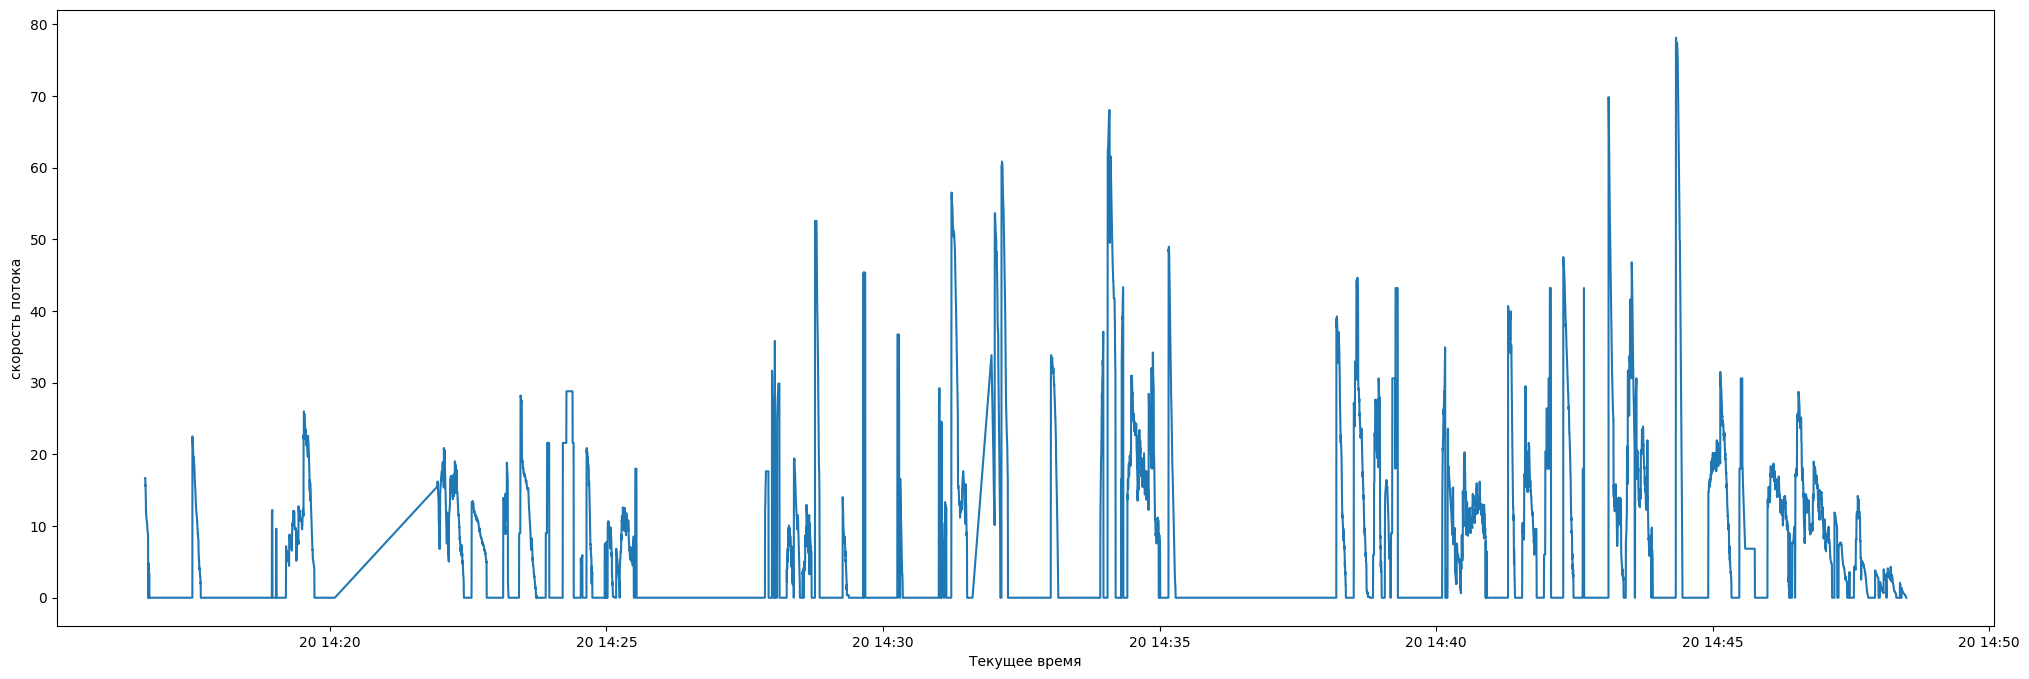

In [161]:
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=mean_speeds_df, x="time", y="0")
ax.set(xlabel='Текущее время', ylabel='скорость потока')
plt.show()

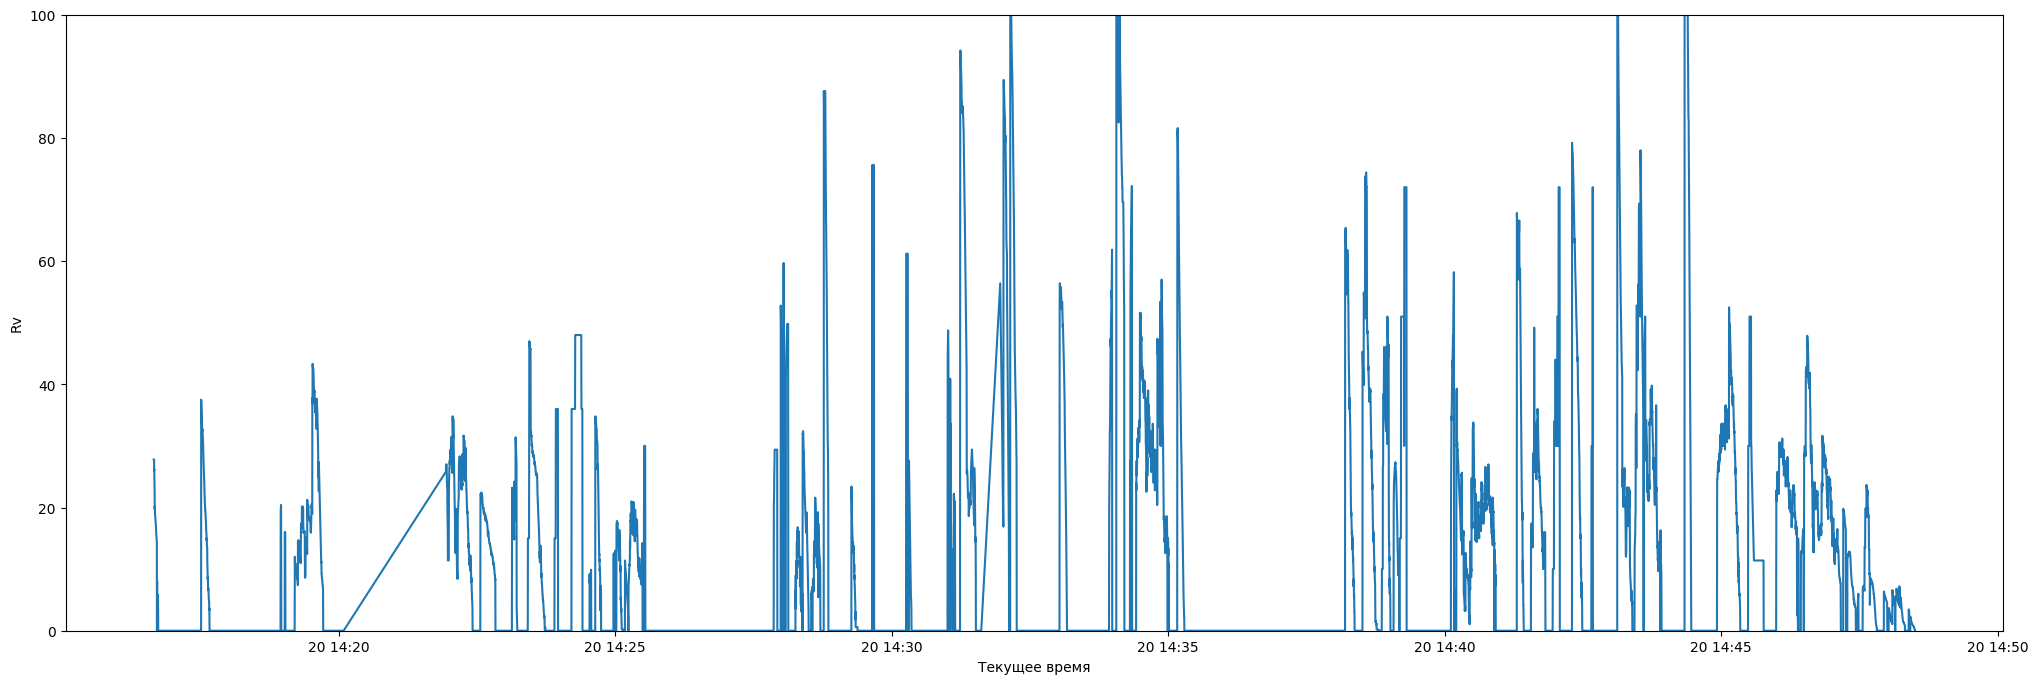

In [162]:
plt.figure(figsize=(25, 8))
ax = sns.lineplot(data=mean_speeds_df, x="time", y="rv_0")
ax.set(xlabel='Текущее время', ylabel='Rv')
plt.ylim(0, 100)
# plt.show()
plt.savefig('rv_0.png')

[Text(0.5, 0, 'Текущее время'), Text(0, 0.5, 'Rv')]

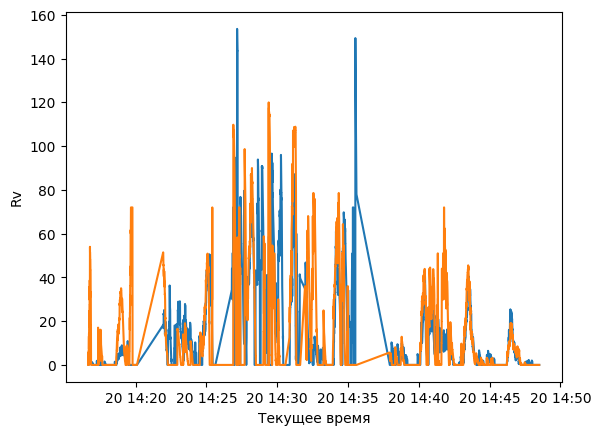

In [163]:
ax = sns.lineplot(data=mean_speeds_df, x="time", y="rv_1")
ax.set(xlabel='Текущее время', ylabel='Rv')
ax = sns.lineplot(data=mean_speeds_df, x="time", y="rv_2")
ax.set(xlabel='Текущее время', ylabel='Rv')

## Задержка (в секунднах)

На каждом шаге итерации суммарная задержка и количество машин рассчитываются как:  

$$
\text{sum_delay} = \sum_{i=1}^{M} \text{delay}_i, \quad \text{sum_cars} = M
$$

где \( M \) — количество машин, покинувших зону на текущем шаге.  

Средняя задержка для текущего шага:  

$$
\text{avg_delay_time} = \frac{\text{sum_delay}}{\text{sum_cars}}
$$

---

Сумма задержек в скользящем окне обновляется при удалении устаревших данных:  

$$
\text{avg_sum} = \text{avg_sum} - \text{car_leaves[0][1]}
$$

где $$\text{car_leaves[0][1]}$$ — задержка самой старой машины в очереди.  

In [164]:
df_objects_31['time'] = pd.to_datetime(df_objects_31['time'])

In [205]:
from collections import deque
from datetime import datetime, timedelta

AVG_VALUE_THRESHOLD_MIN = 3
cars = dict()

standard_time_seconds = 50  # 200 m / 60 km p h


def has_left(curr_dt: datetime, last_seen_dt: datetime) -> bool:
    """car is no longer displayed within the sensor"""
    time_diff = curr_dt - last_seen_dt
    seconds = time_diff.total_seconds()

    return seconds >= 10.0


def calculate_time(curr_dt: datetime, first_seen_dt: datetime) -> float:
    """from first time of stop to current time"""
    time_diff = curr_dt - first_seen_dt
    seconds = time_diff.total_seconds()

    return seconds


def is_traffic_lane(lane: int) -> bool:
    return 0 <= lane <= 2


def car_time(car_id):
    min_dt = datetime.datetime(2070, 1, 1)
    max_dt = datetime.datetime(1970, 1, 1)

    for object_frame in models.objects:
        for car in object_frame.rows_data:
            if car.obj_id == car_id:
                min_dt = min(min_dt, car.time)
                max_dt = max(max_dt, car.time)

    return min_dt, max_dt


def get_max_point_x():
    x_max = 0
    x_min = 10000
    for object_frame in models.objects:
        for car in object_frame.rows_data:
            if is_traffic_lane(car.lane):
                x_max = max(car.point_x, x_max)
                x_min = min(car.point_x, x_min)

    return x_min, x_max


def avg_speed(rows_data: list) -> float:
    return sum(rows_data) / len(rows_data)


def check_heading(angle: int):
    return 160 <= angle <= 200

def calc_avg_delay_time(curr_dt: datetime, avg_sum: float, car_leaves: deque) -> float:
    if not car_leaves:
        return 0.0

    while len(car_leaves) and car_leaves[0][0] < curr_dt - timedelta(minutes=AVG_VALUE_THRESHOLD_MIN):
        avg_sum -= car_leaves[0][1]
        car_leaves.popleft()

    return avg_sum / len(car_leaves)


def calc_time_diff(data: pd.DataFrame):
    avg_sum = 0
    car_leaves = deque()

    avg_times = {
        "avg_delay_time": [],
        "avg_delay_time_secs": [],
        "obj_id": [],
        "lane": [],
        "time": []
    }

    for i, row in data.iterrows():
        curr_dt = row['time']
        if row['obj_id'] not in cars:
            cars[row['obj_id']] = {
                "from_beginning": False,
                "time_entries": []
            }
        if row['point_x'] >= 200:
            cars[row['obj_id']]["from_beginning"] = True
        if row['point_x'] <= 200:
            cars[row['obj_id']]["time_entries"].append((row['time'], row['obj_speed'], row['lane']))

        sum_delay, sum_cars = 0, 0
        ids_to_delete = []

        for car_id, car_data in cars.items():
            from_beginning = car_data["from_beginning"]
            car = car_data["time_entries"]
            if car:
                first_seen_dt = car[0][0]
                last_seen_dt = car[-1][0]

                if has_left(curr_dt, last_seen_dt):
                    if from_beginning and is_traffic_lane(car[0][2]):
                        time_diff = calculate_time(last_seen_dt, first_seen_dt)
                        delay = time_diff - standard_time_seconds
                        sum_delay += delay
                        avg_sum += delay
                        sum_cars += 1
                        car_leaves.append((curr_dt, delay))

                    ids_to_delete.append(car_id)

        for car_id in ids_to_delete:
            del cars[car_id]

        if sum_cars:
            avg_delay_time_secs = max(0, calc_avg_delay_time(curr_dt, avg_sum, car_leaves))
            avg_delay_time = sum_delay / (sum_cars if sum_cars else 1)
            # print(f"avg_delay_time: {avg_delay_time}, avg_delay_time_secs: {avg_delay_time_secs} for "
            #       f"{AVG_VALUE_THRESHOLD_MIN}min")
            avg_times['avg_delay_time'].append(avg_delay_time)
            avg_times['avg_delay_time_secs'].append(avg_delay_time_secs)
            avg_times['obj_id'].append(row['obj_id'])
            avg_times['time'].append(row['time'])
            avg_times['lane'].append(row['lane'])
    return avg_times

In [206]:
avg_times = calc_time_diff(data)

In [207]:
avg_times_df = pd.DataFrame(avg_times)
avg_times_df.head()

,avg_delay_time,avg_delay_time_secs,obj_id,lane,time
0,101.401430,101.401430,71,2,2025-03-20 14:19:26.982336
1,43.195589,72.298509,233,2,2025-03-20 14:19:34.858674
2,-47.483184,32.371278,227,2,2025-03-20 14:19:38.775218
3,86.682413,45.949062,130,1,2025-03-20 14:19:50.774139
4,-2.371526,36.284944,130,1,2025-03-20 14:19:54.471438


In [208]:
avg_times_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   avg_delay_time       149 non-null    float64       
 1   avg_delay_time_secs  149 non-null    float64       
 2   obj_id               149 non-null    int64         
 3   lane                 149 non-null    int64         
 4   time                 149 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 5.9 KB


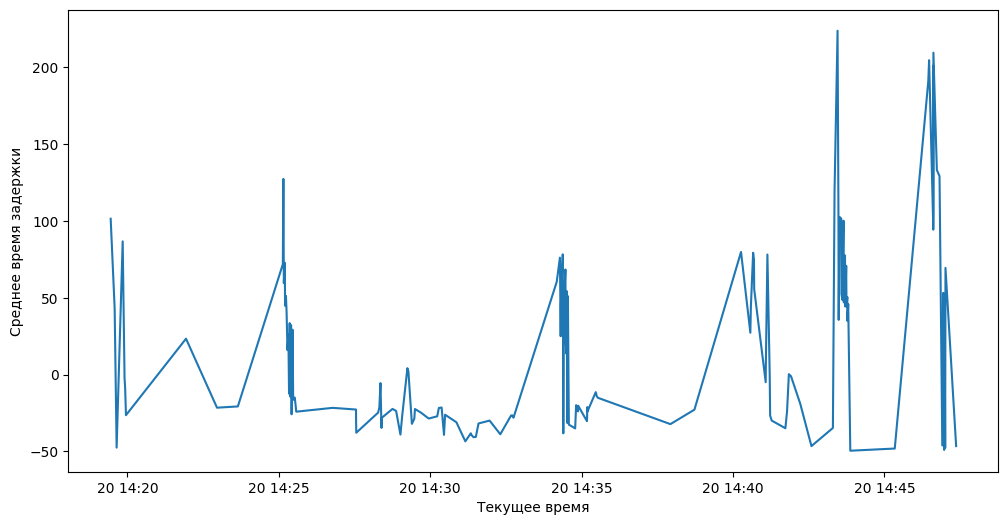

In [209]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=avg_times_df, x="time", y="avg_delay_time")
ax.set(xlabel='Текущее время', ylabel='Среднее время задержки')
plt.show()

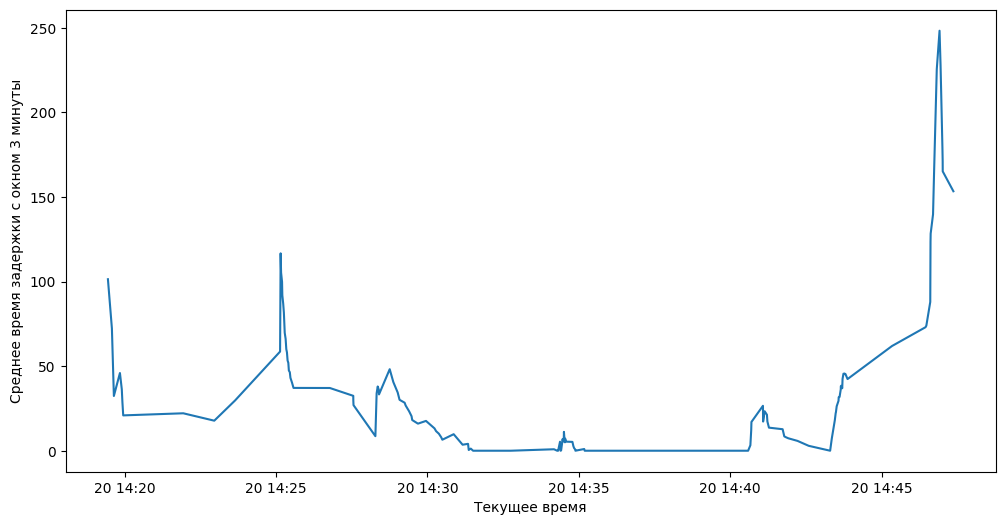

In [213]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=avg_times_df, x="time", y="avg_delay_time_secs")
ax.set(xlabel='Текущее время', ylabel='Среднее время задержки c окном 3 минуты')
# plt.show()
plt.savefig("avg_delay_time_secs.png")

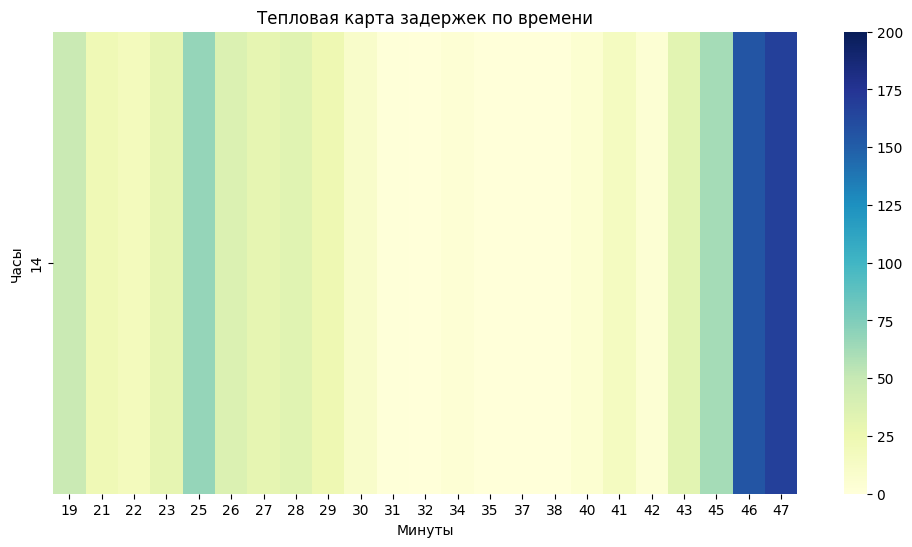

In [211]:
avg_times_df['time'] = pd.to_datetime(avg_times_df['time'])
avg_times_df['hour'] = avg_times_df['time'].dt.hour
avg_times_df['minute'] = avg_times_df['time'].dt.minute

pivot_table = avg_times_df.pivot_table(values='avg_delay_time_secs', index='hour', columns='minute', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', vmin=0, vmax=200)
plt.title('Тепловая карта задержек по времени')
plt.xlabel('Минуты')
plt.ylabel('Часы')
plt.show()

# Очередь в метрах

### 1. Условие движения объекта
$$
\text{is_going} = (v_{max} > 0) ∨ (Δx > 1)
$$
Где:
$$v_{\text{max}}$$ максимальная скорость объекта в последний момент времени
$$\Delta x = x_{\text{max}} - x_{\text{min}}$$ разница между максимальной и минимальной координатой объекта

---

### 2. Определение начала очереди
$$
t_{\text{start}} = \max(\{t_i | t_i \leq t_{\text{current}}\}) - 10\ \text{секунд}
$$
Где временной интервал для анализа определяется через `timedelta`:
$$
[t_{\text{current}} - 10\ \text{с},\ t_{\text{current}}]
$$

---

### 3. Определение конца очереди
$$
\text{Конец очереди} =
\begin{cases}
\text{первый неподвижный объект} & \text{после начала очереди} \\
\text{последний объект в интервале} & \text{если очередь не завершена}
\end{cases}
$$
Реализуется через последовательный анализ объектов в интервале

---

### 4. Расчет длины очереди
$$
L = \sum_{i=1}^{n} (x_{\text{end}}^i - x_{\text{start}}^i)
$$
Где:
$$x_{\text{start}}^i$$ координата начала очереди для i-го транспортного средства
 $$x_{\text{end}}^i$$ координата конца очереди для i-го транспортного средства

In [351]:
from datetime import timedelta
LANES = [0, 1, 2]

def is_going(rows: pd.DataFrame):
  # print(rows[rows['time'] == rows['time'].max()]['obj_speed'])
  if rows[rows['time'] == rows['time'].max()]['obj_speed'].values[0] > 0:
    return True
  elif (rows['point_x'].max() - rows['point_x'].min()) > 1:
    return True
  return False

def get_queue_start(rows: pd.DataFrame):
  for i, row in rows[rows['time'] == rows['time'].max()].iterrows():
    if is_going(rows[rows['obj_id'] == row['obj_id']]):
      return row
  return None


def get_queue_end(rows: pd.DataFrame):
  is_started = False
  for i, row in rows[rows['time'] == rows['time'].max()].iterrows():
    if is_going(rows[rows['obj_id'] == row['obj_id']]):
      is_started = True
    elif is_started:
      return row
  if is_started:
    return rows[rows['time'] == rows['time'].max()].iloc[-1]
  return None

def calculate_queue_meters(data: pd.DataFrame):
  result = {lane: {'starts': [], 'ends': [], 'ts': []} for lane in LANES}
  unique_dt = data['time'].unique()
  rows_by_lane = [data[data['lane'] == lane] for lane in LANES]
  for lane in range(len(rows_by_lane)):
    rows = rows_by_lane[lane]
    for dt in unique_dt:
      start_dt = dt - timedelta(seconds=1)

      start = get_queue_start(rows[(rows['time'] <= dt) & (rows['time'] >= start_dt)])
      end = get_queue_end(rows[(rows['time'] <= dt) & (rows['time'] >= start_dt)])

      try:
          if start.values.tolist() and end.values.tolist():
            result[lane]['starts'].append(start)
            result[lane]['ends'].append(end)
            result[lane]['ts'].append(dt)
      except Exception as e:
          result[lane]['starts'].append(None)
          result[lane]['ends'].append(None)
          result[lane]['ts'].append(dt)
  return result

In [353]:
data = pd.concat([df_objects_20, df_objects_25, df_objects_31])
data['time'] = pd.to_datetime(data['time'])
results = calculate_queue_meters(data)

In [354]:
unique_dt = data['time'].unique()
queue_meters = {
    "time": [],
    "distance": [],
    "front": [],
    "end": [],
    "duration":[],
    "lane": []
}

queue_meters_time = {
    0: None,
    1: None,
    2: None
}


is_finished = {
    0: False,
    1: False,
    2: False
}

for dt in unique_dt:
  for i in LANES:
    lane = results[i]
    index = lane['ts'].index(dt)
    try:
      if lane['starts'][index].values.tolist() and lane['ends'][index].values.tolist():
        start_m = lane['starts'][index]['point_x']
        end_m = lane['ends'][index]['point_x']

        queue_meters['distance'].append(end_m - start_m)
        if (end_m - start_m) < 1:
          start_m = 30
          end_m = 30
          queue_meters_time[i] = dt
          queue_meters['duration'].append(0)
        elif queue_meters_time[i]:
          queue_meters['duration'].append((dt - queue_meters_time[i]).total_seconds())
        else:
          queue_meters['duration'].append(0)
        queue_meters['front'].append(start_m)
        queue_meters['end'].append(end_m)
        queue_meters['time'].append(dt)
        queue_meters['lane'].append(i)
    except Exception as e:
        queue_meters['distance'].append(0)
        queue_meters['front'].append(30)
        queue_meters['end'].append(30)
        queue_meters['time'].append(dt)
        queue_meters['lane'].append(i)
        queue_meters_time[i] = dt
        queue_meters['duration'].append(0)

In [355]:
queue_meters_df = pd.DataFrame(queue_meters)
queue_meters_df['time'] = pd.to_datetime(queue_meters_df['time'])
queue_meters_df.head()

,time,distance,front,end,duration,lane
0,2025-03-20 14:16:39.284801,152.5,38.4,190.9,0.0,0
1,2025-03-20 14:16:39.284801,8.0,41.6,49.6,0.0,1
2,2025-03-20 14:16:39.284801,9.1,37.9,47.0,0.0,2
3,2025-03-20 14:16:39.377547,153.1,37.8,190.9,0.0,0
4,2025-03-20 14:16:39.377547,8.3,41.3,49.6,0.0,1


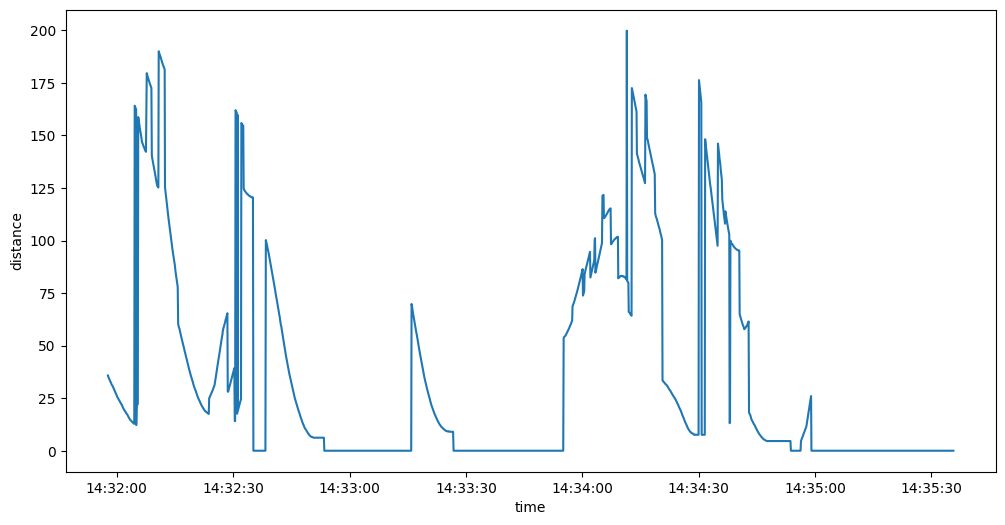

In [347]:
plt.figure(figsize=(12,6))
sns.lineplot(data=queue_meters_df[queue_meters_df['lane'] == 2], x="time", y="distance")
# plt.show()
plt.savefig("distance.png")

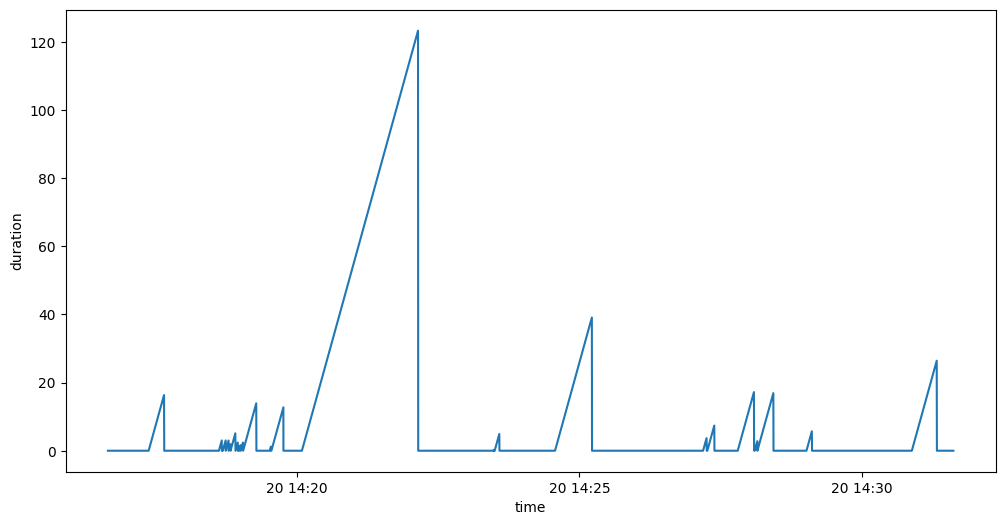

In [357]:
plt.figure(figsize=(12,6))
sns.lineplot(data=queue_meters_df[queue_meters_df['lane'] == 2], x="time", y="duration")
# plt.show()
plt.savefig("duration.png")

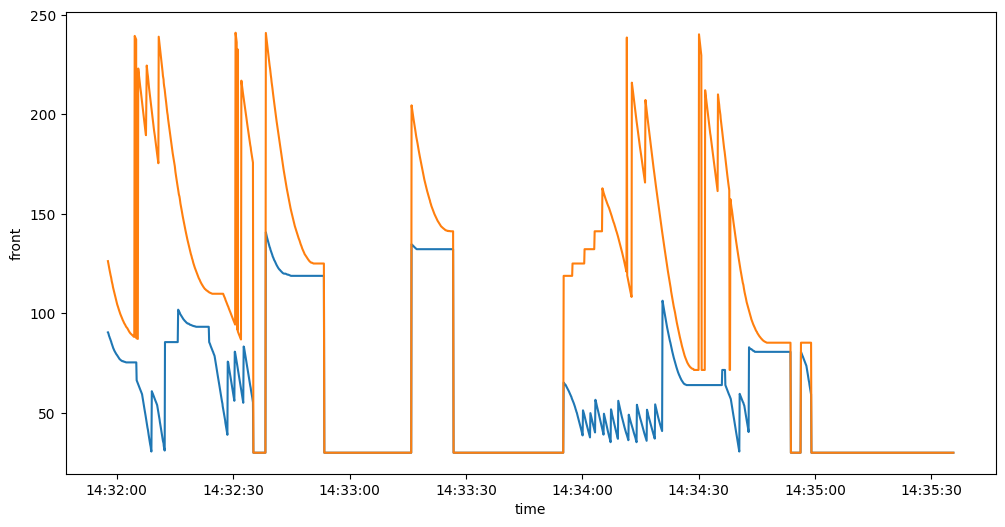

In [326]:
plt.figure(figsize=(12,6))
sns.lineplot(data=queue_meters_df[queue_meters_df['lane'] == 2], x="time", y="front")
sns.lineplot(data=queue_meters_df[queue_meters_df['lane'] == 2], x="time", y="end")
plt.show()
# plt.savefig("фронтыл.png")

# Использованные статьи
Seong, J., Seong, Y., et al. (2023). Measuring traffic congestion with novel metrics: A case study of six U.S. metropolitan areas. ISPRS International Journal of Geo-Information, 12(3), 130. https://doi.org/10.3390/ijgi12030130

He, F., Yan, X., Liu, Y., & Ma, L. (2016). A traffic congestion assessment method for urban road networks based on speed performance index. Procedia Engineering, 137, 425-433. https://doi.org/10.1016/j.proeng.2016.01.277